In [78]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split

# Metrics for scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Plot and graphics
import matplotlib.pyplot as plt
import graphviz

# For printing the confusion matrices at step 4
import pandas as pd
from sklearn.metrics import confusion_matrix
from IPython.core.display import display, HTML

# For printing the ROC plots at step 5
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Classifiers introduction - Exercise implementation

## Your work: what you have to do
Modify the given Jupyter notebook on decision trees on Iris data and perform the following tasks:

1. get an artificial inflation of some class in the training set by a given factor: 10 (weigh more the classes virginica e versicolor which are more difficult to discriminate). Learn the tree in these conditions.
2. modify the weight of some classes (set to 10 the weights for misclassification between virginica into versicolor and vice versa) and learn the tree in these conditions. You should obtain similar results as for step 1.
3. learn trees but try to avoid overfitting (by improving the error on the test set) tuning the hyper-parameters on: the minimum number of samples per leaf, max depth of the tree, min_impurity_decrease parameters, max leaf nodes, etc. Use misclassification error.
4. build the confusion matrix of the created tree models on the test set and show them. 
5. build the ROC curves (or coverage curves in coverage space) and plot them for each tree model you have created: for each model you have to build three curves, one for each class, considered in turn as the positive class. (1-vs-rest model)

In order to implement the fifth step, youi have 2 altenatives: 

1. Implement yourself the function which you need.
2. In the sklearn package, there is thew empirical probability. Decision tree can be set to compute probability for classify each class. In this case the teacher may ask you to explain which function you have use. (clf.predict_proba - Probability prediction foreach classifier)

## Global constant for this notebook.

In [79]:
# Constants
random_state = 300  # Used in the decision tree classifier

## Step 1

Get an artificial inflation of some class in the training set by a given factor: 10 (weigh more the classes virginica e versicolor which are more difficult to discriminate). Learn the tree in these conditions.

### Note on Artificial Inflation

The artificial inflation is a tecnique that allow us to determine the optimum operation point on the coverage plot.

In [80]:
iris = load_iris()

inflation_factor = 10
inflated_iris = dict()

print("The three classes are: {}\n".format(iris.target_names)) # 0: setosa, 1: versicolor, 2: virginica

# Since the only class which we don't want to inflate is setosa (value 0), 
# we can write this single line to obtain an array specifying
# how many times each element of class versicolor and virginica (1 and 2 target_names) has to be repeated
#print(iris.target)
keep = np.clip(iris.target * inflation_factor, a_min=1, a_max=inflation_factor) # target elems with values 0 (setosa, which must not be inflated)
                                                                                # are deleted from this process onf inflation, given the multuplication per 0 (iris.target * inflation_factor), and then normalized to 1s
print("len(keep)={0}\n".format(len(keep)))
#print(keep)

inflated_iris['data'] = np.repeat(iris.data, keep, axis=0)
print(inflated_iris['data'])
inflated_iris['target'] = np.repeat(iris.target, keep, axis=0)
print("len(inflated_iris)={0}\n".format(len(inflated_iris["data"])))
# 50 setosa (50 *1 (50) ), 50 * 10 (500) versicolor and 50 * 10 (500) virginica. Total of 1050 (from the initials 150 (50+50+50)).

# Shuffle the data
np.random.seed(0)
indices = np.random.permutation(len(inflated_iris['data']))
# "indices" is an array containing all the index of "inflated_iris['data']" in random order

# We keep the last 210 indices of 1050 (20%) for test set, the remaining for the training set
indices_training = indices[:-210]
indices_test = indices[-210:]

# training on the first 840 elements
X_train_inf = inflated_iris['data'][indices_training]
y_train_inf = inflated_iris['target'][indices_training]

# testing on the the last 210 elements
X_test_inf = inflated_iris['data'][indices_test]
y_test_inf = inflated_iris['target'][indices_test]

# NOTE: train_test_split() is a method for splitting arrays or matrices into
# random train and test subsets. It does the same as I did in the previuous
# lines by hand. It's more convinient because it's automatic.
# I leave both the procedure because I want to show that splitting the dataset
# by hand, or using sklearn gives us the same results.
#
# Note: "random_state" is a seed input for a number generator.
# X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(inflated_iris['data'],
#                                                                     inflated_iris['target'],
#                                                                     test_size=0.20,
#                                                                     random_state=6)

# fit the model to the training data
clf_inflated = tree.DecisionTreeClassifier(criterion="entropy",
                                           random_state=random_state,
                                           min_samples_leaf=5)
clf_inflated = clf_inflated.fit(X_train_inf, y_train_inf)

# apply fitted model "clf" to the test set 
predicted_y_test_inf = clf_inflated.predict(X_test_inf)

# print the predictions (class numbers associated to classes names in target names)
print("Predictions:\n{0} Length: {1}\n".format(predicted_y_test_inf, len(predicted_y_test_inf)))
print("True classes:\n{0} Length: {1}".format(y_test_inf, len(y_test_inf)))

truth_table = predicted_y_test_inf == y_test_inf

print(f"\nAre the Predictions and True classes the same? {(truth_table).all()}")
print("{0} Length: {1}".format(truth_table, len(y_test_inf)))
print("True: {0} False:{1}".format(sum(truth_table), len(y_test_inf) - sum(truth_table)))

The three classes are: ['setosa' 'versicolor' 'virginica']

len(keep)=150

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 ...
 [5.9 3.  5.1 1.8]
 [5.9 3.  5.1 1.8]
 [5.9 3.  5.1 1.8]]
len(inflated_iris)=1050

Predictions:
[1 2 1 1 2 2 1 1 1 0 1 1 1 1 2 2 2 1 2 1 2 1 2 2 1 2 1 1 1 2 2 0 1 1 1 1 1
 1 2 2 1 1 2 2 1 1 1 2 2 1 2 2 1 0 1 1 2 0 2 0 1 2 0 2 1 0 2 1 2 1 1 2 2 1
 2 2 1 1 1 2 0 2 2 1 2 1 1 1 2 1 2 2 1 2 2 2 1 2 2 1 2 1 1 2 2 1 2 1 2 2 1
 2 2 2 2 1 2 1 2 1 2 1 2 0 2 2 1 1 1 2 2 2 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2
 2 1 0 2 1 1 1 2 1 2 2 1 2 2 1 2 0 1 2 1 1 2 1 1 2 1 1 2 2 1 2 1 1 2 1 2 2
 2 1 2 1 2 2 1 2 1 2 1 2 1 1 2 2 1 2 2 1 2 2 2 2 2] Length: 210

True classes:
[1 2 1 1 2 2 1 1 1 0 1 1 1 1 2 2 2 1 2 1 2 1 2 2 1 2 1 1 1 2 2 0 1 1 1 1 1
 1 2 2 1 1 2 2 1 1 1 2 2 1 2 2 1 0 1 1 2 0 2 0 1 2 0 2 1 0 2 1 2 1 1 2 2 1
 2 2 1 1 1 2 0 2 2 1 2 1 1 1 2 1 2 2 1 2 2 2 1 2 2 1 2 1 1 2 2 1 2 1 2 2 1
 2 2 2 2 1 2 1 2 1 2 1 2 0 2 2 1 1 1 2 2 2 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2
 2 1 0 2 1 1 

### Scoring and graph

Printing final scores and tree.

In [81]:
acc_score_inflated = accuracy_score(y_test_inf, predicted_y_test_inf)
print("Accuracy score:\t{}".format(acc_score_inflated))

# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0.
f1_inflated = f1_score(y_test_inf, predicted_y_test_inf, average='macro')
print("F1 score:\t{}".format(f1_inflated))

Accuracy score:	1.0
F1 score:	1.0


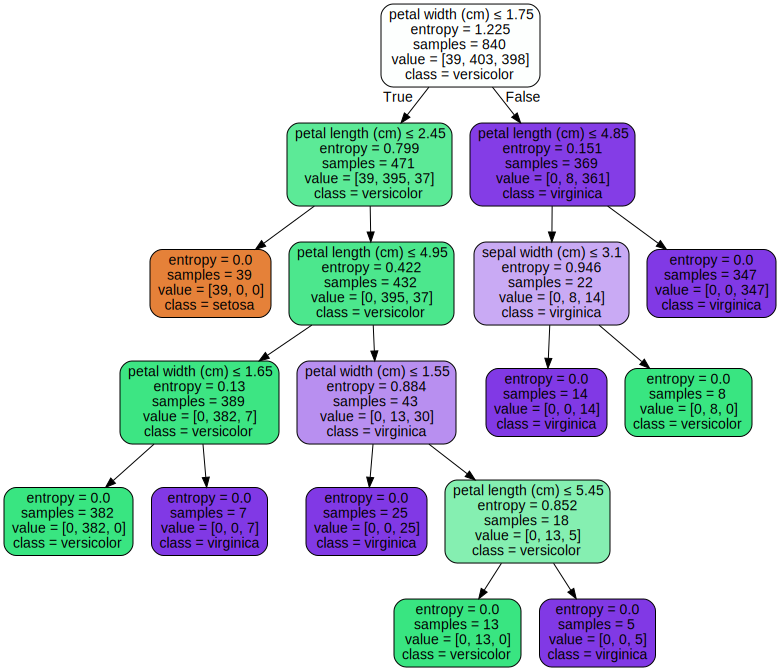

In [82]:
# Printing training tree
dot_data_w = tree.export_graphviz(clf_inflated, out_file=None,
                                  feature_names=iris.feature_names,
                                  class_names=iris.target_names,
                                  filled=True, rounded=True,
                                  special_characters=True)
graph = graphviz.Source(dot_data_w)
graph

## Step 2

Modify the weight of some classes (set to 10 the weights for misclassification between virginica into versicolor and vice versa) and learn the tree in these conditions. You should obtain similar results as for step 1.

In [83]:
# Note: decreasing min_samples_leaf both the accuracy and F1 score are better! 
# (the default for min_samples_leaf is 1)
clf_weighted = tree.DecisionTreeClassifier(criterion="entropy",
                                           random_state=random_state,
                                           min_samples_leaf=5,
                                           class_weight={0:1,1:10,2:10})

# Load iris data
X, y = load_iris(return_X_y=True)

# Random state is for reproducing the same test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=7)
# 20% of 150 is 30.

# fit the model to the original training data
clf_weighted = clf_weighted.fit(X_train, y_train)

# apply fitted model "clf_weighted" to the test set
predicted_y_test_w = clf_weighted.predict(X_test)

# print the predictions (class numbers associated to classes names in
# target names)
print(f"Predictions:\n{predicted_y_test_w} Length: {len(predicted_y_test_w)}\n")
print(f"True classes:\n{y_test} Length: {len(y_test)}")

truth_table = predicted_y_test_w == y_test

print(f"\nAre the Predictions and True classes the same? {(truth_table).all()}")
print(f"{truth_table} Length: {len(y_test)}")
print(f"True: {sum(truth_table)} False:{len(y_test) - sum(truth_table)}")

Predictions:
[2 1 0 1 2 0 1 1 0 1 2 1 0 2 0 2 2 2 0 0 1 2 1 1 1 2 1 1 2 2] Length: 30

True classes:
[2 1 0 1 2 0 1 1 0 1 1 1 0 2 0 1 2 2 0 0 1 2 1 2 2 2 1 1 2 2] Length: 30

Are the Predictions and True classes the same? False
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True False
 False  True  True  True  True  True] Length: 30
True: 26 False:4


### Scoring and graph

Printing final scores and tree.

In [84]:
acc_score = accuracy_score(y_test, predicted_y_test_w)
print("Accuracy score:\t{}".format(acc_score))

# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, predicted_y_test_w, average='macro')
print("F1 score:\t{}".format(f1))

Accuracy score:	0.8666666666666667
F1 score:	0.883838383838384


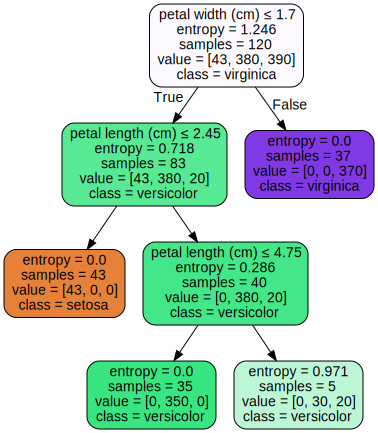

In [85]:
# Printing training tree
dot_data_w = tree.export_graphviz(clf_weighted, out_file=None,
                         feature_names=iris.feature_names,
                         class_names=iris.target_names,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data_w)
graph

## Step 3

Learn trees but try to avoid overfitting (by improving the error on the test set) tuning the hyper-parameters on: the minimum number of samples per leaf, max depth of the tree, min_impurity_decrease parameters, max leaf nodes, etc. Use misclassification error.

In [86]:
# We create a different DecisionTree with tuned params class_weight={0:1,1:1,2:1}
clf_refined = tree.DecisionTreeClassifier(criterion="entropy",
                                          random_state=random_state,
                                          min_samples_leaf=30,
                                          max_leaf_nodes=10,
                                          min_samples_split=20,
                                          min_impurity_decrease=0.05)

# fit the new model to the original training data
clf_refined = clf_refined.fit(X_train, y_train)

# apply fitted model "clf" to the test set
predicted_y_test_ref = clf_refined.predict(X_test)

# print the predictions (class numbers associated to classes names in target names)
print(f"Predictions:\n{predicted_y_test_ref} Length: {len(predicted_y_test_ref)}\n")
print(f"True classes:\n{y_test} Length: {len(y_test)}")

truth_table = predicted_y_test_ref == y_test

print(f"\nAre the arrays Predictions and True classes the same? {(truth_table).all()}")
print(f"{truth_table} Length: {len(truth_table)}")
print(f"True: {sum(truth_table)} False:{len(y_test) - sum(truth_table)}")

Predictions:
[2 1 0 1 2 0 1 1 0 1 2 1 0 2 0 2 2 2 0 0 1 2 1 1 1 2 1 1 2 2] Length: 30

True classes:
[2 1 0 1 2 0 1 1 0 1 1 1 0 2 0 1 2 2 0 0 1 2 1 2 2 2 1 1 2 2] Length: 30

Are the arrays Predictions and True classes the same? False
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True False
 False  True  True  True  True  True] Length: 30
True: 26 False:4


### Scoring and graph

Printing final scores and tree.

In [87]:
acc_score_ref = accuracy_score(y_test, predicted_y_test_ref)
print("Accuracy score:\t{}".format(acc_score_ref))

# The F1 score is the macro avg between recall and precison
f1_ref = f1_score(y_test, predicted_y_test_ref, average='macro') 
print("F1 score:\t{}".format(f1_ref))

Accuracy score:	0.8666666666666667
F1 score:	0.883838383838384


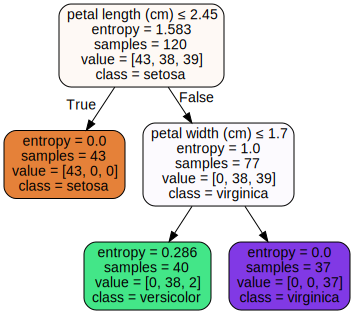

In [88]:
# Printing training tree
dot_data = tree.export_graphviz(clf_refined, out_file=None,
                         feature_names=iris.feature_names,
                         class_names=iris.target_names,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

## Step 4

Build the confusion matrix of the created tree models on the test set and show them.

In [89]:
def display_side_by_side(dfs:list, captions:list):
    """ Display tables side by side to save vertical space.
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    print()  # for prettier output
    display(HTML(output))

# Predict probability
#scores = clf_weighted.predict_proba(X_test)[:,1]

# Compute confusion matrix to evaluate the accuracy of a classification.
inflated_cf_matrix = confusion_matrix(y_true=y_test_inf,
                                      y_pred=predicted_y_test_inf)
weighted_cf_matrix = confusion_matrix(y_true=y_test,
                                      y_pred=predicted_y_test_w)
refined_cf_matrix = confusion_matrix(y_true=y_test,
                                     y_pred=predicted_y_test_ref)

index = ["setosa (act)", "versicolor (act)", "virginica (act)"] #rows = actual labels
columns = ["setosa (pred)", "versicolor (pred)", "virginica (pred)"] #columns = predicted labels

df_inflated = pd.DataFrame(inflated_cf_matrix, index, columns)
df_weighted = pd.DataFrame(weighted_cf_matrix, index, columns)
df_refined = pd.DataFrame(refined_cf_matrix, index, columns)

captions = ["Confusion Matrix - Inflated Tree",
            "Confusion Matrix - Weighted Tree",
            "Confusion Matrix - Refined Tree"]

# Pretty print the three confusion matrix
display_side_by_side([df_inflated, df_weighted, df_refined], captions)


,setosa (pred),versicolor (pred),virginica (pred)
setosa (act),11,0,0
versicolor (act),0,97,0
virginica (act),0,0,102
,setosa (pred),versicolor (pred),virginica (pred)
setosa (act),7,0,0
versicolor (act),0,10,2
virginica (act),0,2,9
,setosa (pred),versicolor (pred),virginica (pred)
setosa (act),7,0,0
versicolor (act),0,10,2


## Step 5

Build the ROC curves (or coverage curves in coverage space) and plot them for each tree model you have created: for each model you have to build three curves, one for each class, considered in turn as the positive class. (1-vs-rest model)

Initializing the configuratuion for the plots.

In [90]:
# Save iris data
X_plot = iris.data
y_plot = iris.target

# Binarize the output
y_plot = label_binarize(y_plot, classes=[0, 1, 2])
n_classes = y_plot.shape[1]
#print(y_plot)
#print(n_classes)

# shuffle and split training and test sets
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_plot, y_plot, test_size=0.20, random_state=7)

# Subplot configuration
subplot_kw = dict(
    xlabel=('False Positive Rate'),
    ylabel=('True Positive Rate'),
    xlim=([0.0, 1.0]),
    ylim=([0.0, 1.05]))

Defining some utility functions.

In [91]:
def calculate_actuals_binary(class_index, y_test):
    """
    Calculates a binary array in a one vs many (all) fashion 
    (1 if the actual class corresponds to the index, 0 otherwise).
    """
    # Actual is a vector containing 1 only if the correct class
    # corresponds to the current class (determined by index i)
    actual = np.zeros(y_test.shape[0])
    for j in range(y_test.shape[0]):
        if y_test[j] == class_index:
            actual[j] = 1

    return actual

 
def calculate_scores():
    """
    Appends the binary array for each class (for each (3) 1 vs all computation)
    """
    result = np.zeros([n_classes, y_test.shape[0]])
    for i in range(n_classes): # 0, 1, 2 (n_classes = 3)
        array = calculate_actuals_binary(i, y_test)
        result[i] = array

    return result


# As seen in the documentation 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def compute_roc(classifier, weighted: bool):
    # Learn to predict each class against the other
    # Differente procedure in case the clf has weight
    if weighted:
        y_train_binary = calculate_scores()
        #print(y_train_binary)
        y_score_bin = classifier.predict_proba(X_test)
        print(y_score_bin)
        # Returns the probability of the sample for each class in the model, where classes are ordered as they are 
        # in self.classes_.
    else:
        classifier = OneVsRestClassifier(classifier)
        y_score_bin = classifier.fit(X_train_bin, y_train_bin).predict_proba(X_test_bin)
        # Predict each probability

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = roc_curve(y_test_bin[:, i],  #comparing prob prediction (y_Score) for each class with y_test_bin (y_true) for that class
                                               y_score_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return (fpr, tpr, roc_auc)


def plot_roc_curves(title: str, fpr, tpr, roc_auc):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                        figsize=(24, 6), subplot_kw=subplot_kw)
    """
    Plot roc curves, one for each class of the datases.
    """

    ax0.set_title('setosa (act)')
    lw = 0
    ax0.plot(fpr[lw], tpr[lw], color='red', lw=lw, 
             label='ROC curve (area = {0:0.2f})'.format(roc_auc[lw]))
    ax0.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax0.legend(loc="lower right")

    ax1.set_title('versicolor (act)')
    lw = 1
    ax1.plot(fpr[lw], tpr[lw], color='green', lw=lw, 
             label='ROC curve (area = {0:0.2f})'.format(roc_auc[lw]))
    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.legend(loc="lower right")

    ax2.set_title('virginica (act)')
    lw = 2
    ax2.plot(fpr[lw], tpr[lw], color='purple', lw=lw, 
             label='ROC curve (area = {0:0.2f})'.format(roc_auc[lw]))
    ax2.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax2.legend(loc="lower right")

    fig.suptitle('ROC curves for {}'.format(title))

    return fig

### Plotting ROC curves

#### Inflated case

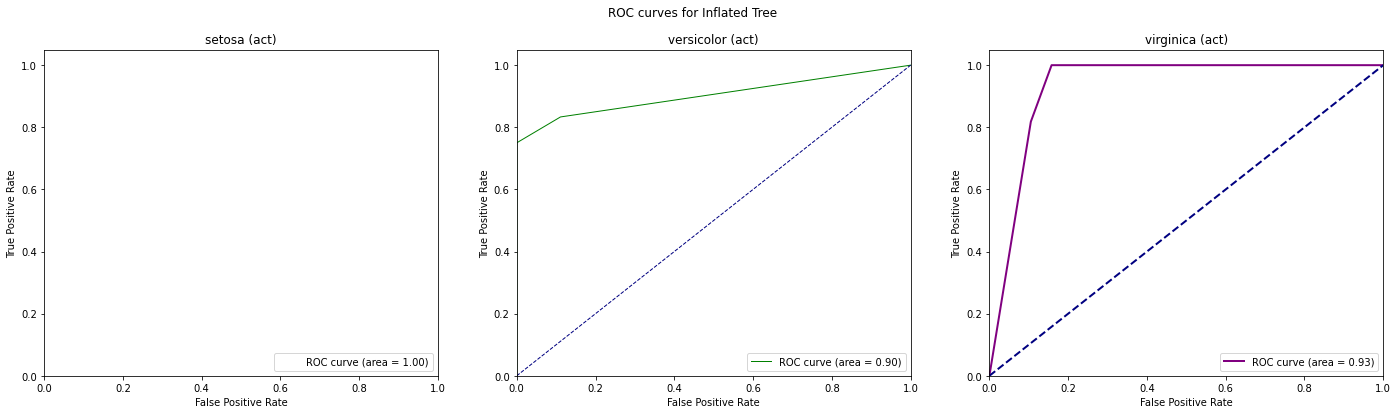

In [92]:
# Inflated case
classifier: tree.DecisionTreeClassifier = clf_inflated
title: str = "Inflated Tree"

frp, tpr, roc_auc = compute_roc(classifier, False)
to_plot = plot_roc_curves(title, frp, tpr, roc_auc)

#### Weighted case

[[0.  0.  1. ]
 [0.  1.  0. ]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [1.  0.  0. ]
 [0.  0.6 0.4]
 [0.  1.  0. ]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [0.  1.  0. ]
 [1.  0.  0. ]
 [0.  0.  1. ]
 [1.  0.  0. ]
 [0.  0.  1. ]
 [0.  0.  1. ]
 [0.  0.  1. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [0.  1.  0. ]
 [0.  0.6 0.4]
 [0.  0.6 0.4]
 [0.  0.  1. ]
 [0.  1.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [0.  0.  1. ]]


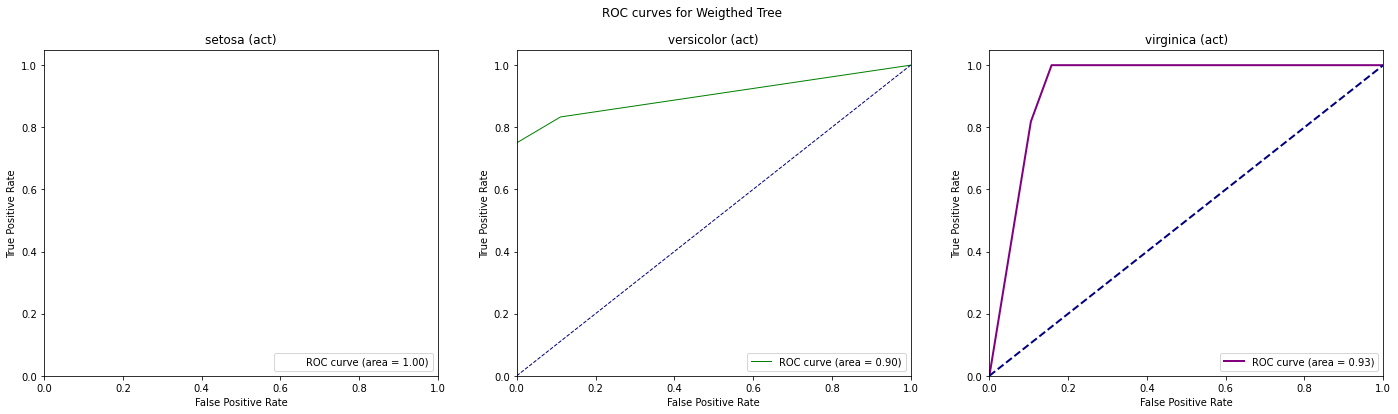

In [93]:
# Weigthed case
classifier: tree.DecisionTreeClassifier = clf_weighted
title: str = "Weigthed Tree"

frp, tpr, roc_auc = compute_roc(classifier, True)
to_plot = plot_roc_curves(title, frp, tpr, roc_auc)

#### Refined case

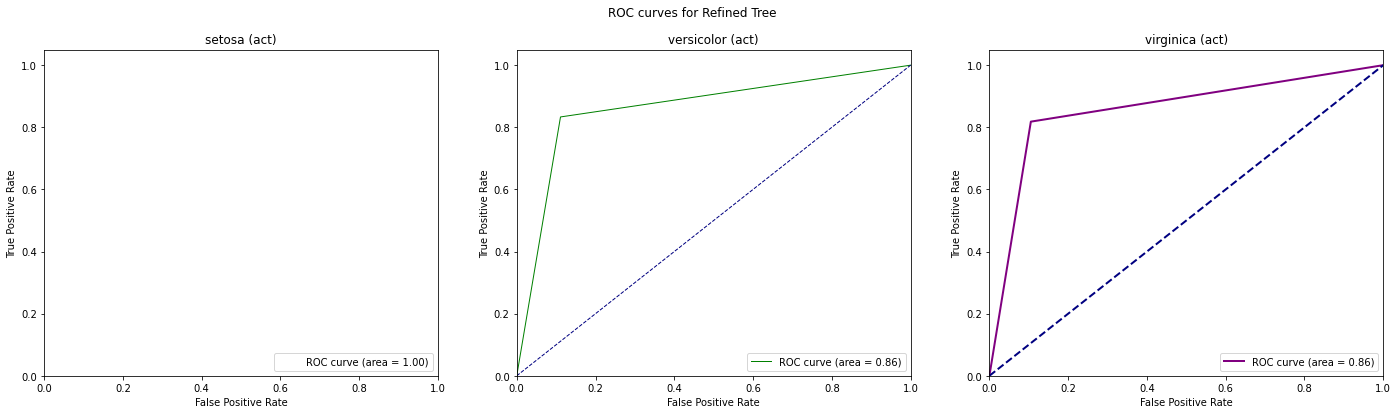

In [94]:
# Refined case
classifier: tree.DecisionTreeClassifier = clf_refined
title: str = "Refined Tree"

frp, tpr, roc_auc = compute_roc(classifier, False)
to_plot = plot_roc_curves(title, frp, tpr, roc_auc)